### Kriptonite

A draft krypton analyis

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-03-24 00:19:55


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np

import operator
import functools
import copy
import glob

import matplotlib.pyplot as plt

In [4]:
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.sierpe.blr as blr
import invisible_cities.reco.peak_functions_c as cpf
from invisible_cities.core.mpl_functions import set_plot_labels
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.database import load_db

In [10]:
from event_pmaps import EventPmaps, KrConditions, KrSelection, print_s12, print_s2si

In [11]:
from histo_functions import hist, hist2d, log_pdf, pdf, scatter, save_to_folder

In [ ]:
from kr_base import kr_writer

### run number

In [6]:
run_number=3379

### Data base

In [7]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)

In [8]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,22,PMT1,1,-23.9414,65.7785,0.00080,0.000001,25.39,0.7160,9.474
1,1,18,PMT3,1,-44.9951,-53.6231,0.00080,0.000001,26.49,0.8744,10.510
2,2,23,PMT2,1,68.9365,-12.1554,0.00080,0.000001,27.74,0.7303,9.031
3,3,0,PMT4,1,0.0000,185.0000,0.00161,0.000003,25.17,0.7060,8.720
4,4,31,PMTC,1,-118.9160,141.7180,0.00160,0.000003,26.56,0.7000,8.910
5,5,8,PMTB,1,-182.1890,32.1249,0.00161,0.000003,21.55,0.7278,6.900
6,6,5,PMTA,1,-160.2150,-92.5000,0.00161,0.000003,23.86,0.7323,7.860
7,7,4,PMT9,1,-63.2737,-173.8430,0.00161,0.000003,33.57,0.7206,11.750
8,8,1,PMT8,1,63.2737,-173.8430,0.00162,0.000003,22.15,0.7213,7.070
9,10,27,PMT6,1,182.1890,32.1249,0.00080,0.000001,20.83,0.7921,6.780


### General plot options

In [9]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "./plots/pmaps"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Useful functions borrowed from Gonzaponte

In [12]:
def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


save = functools.partial(save_to_folder, outputfolder)

In [ ]:
class KrBox:
    """Container of krypton events"""
    def __init__(self, run_number):
        self.run_number = run_number
        self.event_ = []
        self.s1f_ = S12F()
        self.s2f_ = S12F()
        self.qs1_ = []
        self.qs2_ = []
        self.drift_ = []
        self.X_ = []
        self.Y_ = []
        self.Z_ = []
        self.R_ = []
        self.Phi_ = []

    def event(self):
        return np.array(self.event_)
    def s1f(self):
        return np.array(self.s1f)
    def s2f(self):
        return np.array(self.s2f)
    def qs1(self):
        return np.array(self.qs1)
    def qs2(self):
        return np.array(self.qs2)
    def drift(self):
        return np.array(self.drift)
    def X(self):
        return np.array(self.X_)
    def Y(self):
        return np.array(self.Y_)
    def Z(self):
        return np.array(self.Z_)
    def R(self):
        return np.array(self.R_)
    def Phi(self):
        return np.array(self.Phi_)



### Main driver

In [ ]:
def kryptonite(input_files, output_file):
    """Main driver"""
    with pmap_writer(self.output_file, self.compression) as write:
            if self.monte_carlo:
                mctrack_writer = MCTrackWriter(write.file)
            # loop over input files
            for ffile in self.input_files:
                print("Opening", ffile, end="... ")
                filename = ffile
                with tb.open_file(filename, "r") as h5in:

                    # access RWF
                    pmtrwf  = h5in.root.RD. pmtrwf
                    sipmrwf = h5in.root.RD.sipmrwf

                    self.eventsInfo = h5in.root.Run.events
                    # last row copied from MCTracks table
                    if self.monte_carlo:
                        mctrack_row = 0

                    NEVT, NPMT,   PMTWL =  pmtrwf.shape
                    NEVT, NSIPM, SIPMWL = sipmrwf.shape
                    sensor_param = SensorParams(NPMT   = NPMT,
                                                PMTWL  = PMTWL,
                                                NSIPM  = NSIPM,
                                                SIPMWL = SIPMWL)
                    print("Events in file = {}".format(NEVT))

                    if not first:
                        self.print_configuration(sensor_param)
                        first = True
                    # loop over all events in file unless reach nmax
                    for evt in range(NEVT):
                        if self.monte_carlo:
                            # copy corresponding MCTracks to output MCTracks table
                            mctrack_writer.copy_mctracks(h5in.root.MC.MCTracks,
                                          n_events_tot)



In [ ]:
def kryptonite(run_number, 
               pmtrwf, 
               sipmrwf, 
               event_list=list(range(1)),
               event_plot_list=list(range(1)),
               printout=10):

    """Select Kripton like events.
       Selection criteria
       nS1 = 1 & nS2 = 1
    """
    # searches
    s1par  = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=20, stride=4, rebin=False)
    s2par = S12Params(tmin=640*units.mus, tmax=670*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)
    
    thr    = ThresholdParams(thr_s1=0.5 * units.pes,  thr_s2=1 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)
    
    # instance of EventPmaps
    epm = EventPmaps(run_number, pmtrwf, sipmrwf, s1par, s2par, thr, verbose=False)
    
    # instance of KryptonBox
    krb = KrBox(run_number)
    
    # Krypton selection
    krs = KrSelection(s1_multiplicity=1,
                      s2_multiplicity=1,
                      si_multiplicity=1)
    
    drift_velocity = 0.9 * units.mm/units.mus

    # start loop
    for event in event_list:
        
        epm.verbose = False
        if(event%printout == 0):
            print('processing event number {}'.format(event))
            epm.verbose = True

        csum = epm.calibrated_sum(event)
        
        if csum == 0:
            return KrConditions.csum_is_zero
        
        ns1 = epm.find_s1(event)
        ns2 = epm.find_s2(event)

        if ns1 != krs.s1_multiplicity:
            return KrConditions.s1_multiplicity

        if ns2 != krs.s2_multiplicity:
            return KrConditions.s2_multiplicity

        krb.s1f.add_features(event, self.S1, peak_number=0)
        krb.s2f.add_features(event, self.S2, peak_number=0)

        nsi = epm.find_s2si(event)

        if nsi != 1:
            return KrConditions.si_multiplicity
        
        # drift time
        ts1 = epm.s1f.self.tpeak_[event]
        ts2 = epm.s2f.self.tpeak_[event]
        
        drift_time = ts2 - ts1 
        
        # position from silicon
        xsipm, ysipm, Q = epm.charge_and_position(peak_number=0)
        
        X    = np.average(xsipm, weights=Q) if np.any(Q) else np.nan
        Y    = np.average(ysipm, weights=Q) if np.any(Q) else np.nan
        R    = (X**2 + Y**2)**0.5 if np.any(Q) else np.nan
        Phi  = np.arctan2(Y, X) if np.any(Q) else np.nan
        Z    = drift_time * drift_velocity 
        
        krb.add_position(X,Y,Z,R,Phi, drift_time)

        


In [40]:
def scan_events(epm, event_list=list(range(1)), event_plot_list=list(range(1)), printout=10):
    """Loop over events"""
    
    for event in event_list:
        if(event%printout == 0):
            print('processing event number {}'.format(event))
            epm.verbose = True
        epm.calibrated_sum(event)
        epm.find_s1(event)
        epm.find_s2(event)
        if (len(epm.S2) > 0):
            epm.find_s2si(event)
        epm.verbose = False

### Input

In [47]:
run_number=3379

In [49]:
RWF_file = os.path.join(os.environ['IC_DATA'],
                        'LSC/{}/dst_waves.gdcsnext.000_{}.root.h5'.format(run_number, run_number))

In [50]:
h5rwf = tb.open_file(RWF_file,'r')

In [51]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [52]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 163
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


### S12 searches

In [45]:
s1par  = S12Params(tmin=0*units.mus, tmax=640*units.mus, lmin=6, lmax=20, stride=4, rebin=False)
s2par = S12Params(tmin=640*units.mus, tmax=800*units.mus, stride=40, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=0.5 * units.pes,  thr_s2=1 *units.pes,
                        thr_MAU = 3 * units.adc, thr_sipm = 3.5 * units.pes,
                        thr_SIPM = 30 * units.adc)

### Instance of event Pmaps

In [57]:
epm = EventPmaps(run_number, pmtrwf, sipmrwf, s1par, s2par, thr, verbose=False)

### Run

In [60]:
n_events = 160
sample_plot = 10
t0 = time.time()
scan_events(epm, event_list=list(range(n_events)), event_plot_list=list(range(0,n_events,sample_plot)))
t1 = time.time()        
dt = t1 - t0
print("run {} events in {} s event/s = {}".format(n_events, dt, dt/n_events))

processing event number 0
number of peaks = 1
S12 number = 0, samples = 9 sum in pes =10.384952485454287
time vector (mus) = [ 472.875  472.9    472.925  472.95   472.975  473.     473.025  473.05
  473.075]
energy vector (pes) = [ 0.65628716  1.39993223  1.66368962  1.77933408  1.43722909  1.11834895
  0.95429964  0.77174684  0.60408487]
number of peaks = 1
S12 number = 0, samples = 9 sum in pes =3715.840224033471
time vector (mus) = [ 648.83    649.9125  650.9125  651.9125  652.9125  653.9125  654.9125
  655.9125  656.889 ]
energy vector (pes) = [  84.85539031  238.22198898  470.12702965  708.85031703  906.14634959
  672.39886346  428.3109597   167.47978362   39.4495417 ]
S2Si for peak number = 0
sipm number = 409, energy = 35.13352675302447
processing event number 10
number of peaks = 1
S12 number = 0, samples = 9 sum in pes =12.733141251372082
time vector (mus) = [ 531.25   531.275  531.3    531.325  531.35   531.375  531.4    531.425
  531.45 ]
energy vector (pes) = [ 0.74129402  

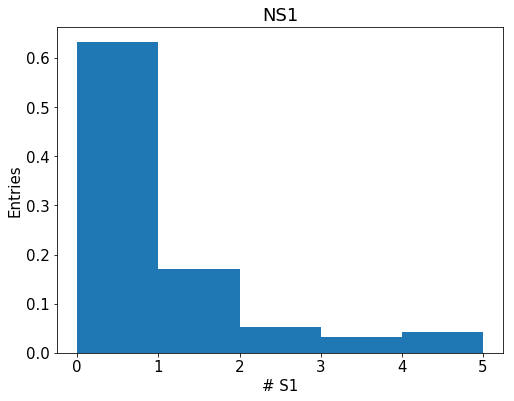

In [61]:
pdf(epm.s1f.peak(), 5, range=(0, 5))
labels("# S1", "Entries")
save("NS1")

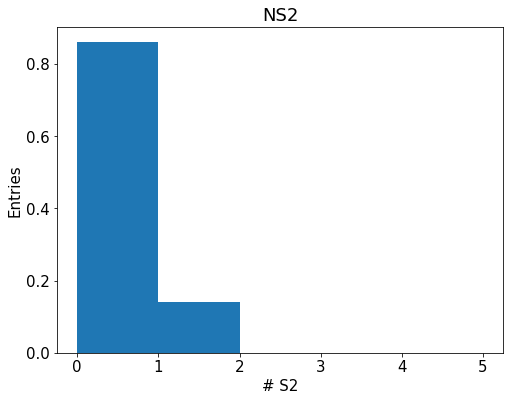

In [62]:
pdf(epm.s2f.peak(), 5, range=(0, 5))
labels("# S2", "Entries")
save("NS2")

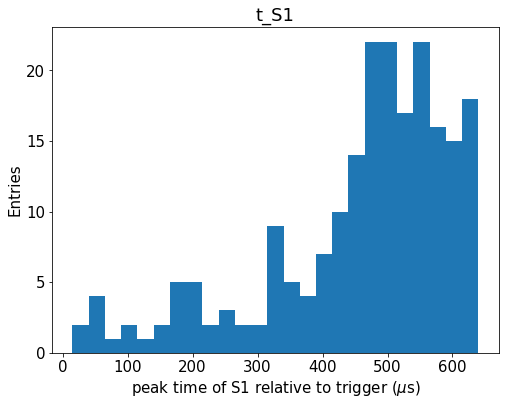

In [63]:
hist(epm.s1f.tpeak()/units.mus, 25)
labels("peak time of S1 relative to trigger ($\mu$s)", "Entries")
save("t_S1")

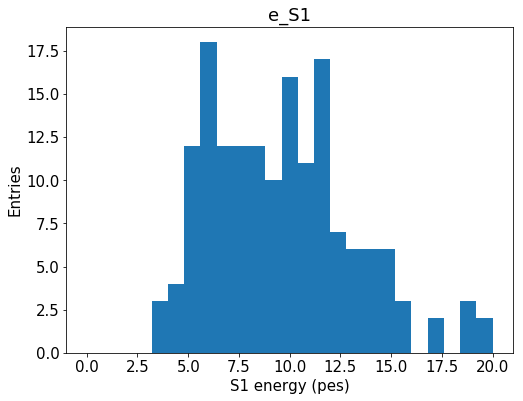

In [64]:
hist(epm.s1f.etot(), 25,(0,20))
labels("S1 energy (pes)", "Entries")
save("e_S1")

In [67]:
s1_eq_1 = epm.s1f.peak() == 0  # peak= 0 means nS1 = 1

In [68]:
s1_eq_1  # The outcome is a selection array

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,

In [69]:
nS1_1 = epm.s1f.peak()[s1_eq_1] # this is an array such that ns1 = 1

In [70]:
nS1_1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [71]:
nS2_nS1_1 = epm.s2f.peak()[s1_eq_1] # this is an array of nS2 such that ns1 = 1

/home/icuser/miniconda/envs/IC3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 186 but corresponding boolean dimension is 212
  if __name__ == '__main__':


IndexError: index 187 is out of bounds for axis 1 with size 186

In [72]:
len(epm.s1f.peak())

212

In [73]:
len(epm.s2f.peak())

186

In [ ]:
nS1 = np.array([…]
S1E = np.array([...])
S2E = np.array([…])

selection = nS1 == 1 # esto es un np.array con True donde se cumple la condición
nS1_1 = nS1[selection]  # esto el vector de nS1 reducido a aquellos que tienen exactamente 1 S1
S1E_1 = S1E[selection]  # esto el vector de S1E reducido a aquellos que tienen exactamente 1 S1
S2E_1 = S2E[selection]  # esto el vector de S2E reducido a aquellos que tienen exactamente 1 S1


plt.plot(S1E_1, S2E_1)

In [21]:
gui.add_figure('s1 peaks ',hist_1d(epm.s1f.peak(), xlo=0, xhi=max(epm.s1f.peak()) + 1))
gui.add_figure('s1 width in ns',hist_1d(epm.s1f.width(), xlo=0, xhi=500))
gui.add_figure('s1 t in mus',hist_1d(epm.s1f.tpeak()/units.mus, xlo=0, xhi=650))
gui.add_figure('s1 etot in pes',hist_1d(epm.s1f.etot(), xlo=0, xhi=max(epm.s1f.etot())+10))
gui.add_figure('s1 etot in pes (2)',hist_1d(epm.s1f.etot(), xlo=0, xhi=100))
gui.add_figure('s1 emax in pes',hist_1d(epm.s1f.emax(), xlo=0, xhi=max(epm.s1f.emax())+10))
gui.add_figure('s1 emax/etot in pes',hist_1d(epm.s1f.emax_over_etot(), xlo=0, xhi=1))

In [20]:
gui.add_figure('s2 peaks ',hist_1d(epm.s2f.peak(), xlo=0, xhi=max(epm.s2f.peak()) + 1))
gui.add_figure('s2 width in mua',hist_1d(epm.s2f.width()/units.mus, xlo=0, xhi=max(epm.s2f.width()/units.mus)+10))
gui.add_figure('s2 t in mus',hist_1d(epm.s2f.tpeak()/units.mus, xlo=650, xhi=670))
gui.add_figure('s2 etot in pes',hist_1d(epm.s2f.etot(), xlo=0, xhi=max(epm.s2f.etot())+100))
gui.add_figure('s2 emax in pes',hist_1d(epm.s2f.emax(), xlo=0, xhi=max(epm.s2f.emax())+100))
gui.add_figure('s2 emax/etot in pes',hist_1d(epm.s2f.emax_over_etot(), xlo=0, xhi=1))